In [6]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scanpy as sc
import scanpy.external as sce
import scipy
import scipy.sparse as sp
import sklearn
from scipy.sparse import csr_matrix

from importlib import reload

# local imports
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3  

# load the Data

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/scanpy/native_hsc_sc_fib.h5ad"
adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()
adata

Memory usage: current 20.43 GB, difference +20.43 GB


AnnData object with n_obs × n_vars = 33726 × 17975
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_id', 'cluster_str', 'new_cluster'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cluster_str_colors', 'dataset_colors', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'pca', 'standard_cell_type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'combat', 'counts', 'log_norm', 'magic', 'norm'
    obsp: 'connectivities', 'distances'

In [10]:
def filter_genes_by_group_min_count(adata, group_key, min_count):
    """Filters genes in an AnnData object based on minimum count within all groups.

    Args:
        adata: The AnnData object.
        group_key: The key in `adata.obs` that defines the groups.
        min_count: The minimum count required for a gene within each group.

    Returns:
        AnnData: A new AnnData object with the filtered genes.
    """

    gene_mask = None
    for group_name in adata.obs[group_key].unique():
        group_adata = adata[adata.obs[group_key] == group_name, :]
        gene_counts = group_adata.X.sum(axis=0)
        group_mask = gene_counts >= min_count
        print(f"{group_key}: {group_name} - {group_mask.sum()} genes pass filter")

        if gene_mask is None:
            gene_mask = group_mask
        else:
            gene_mask = gene_mask & group_mask

    filtered_adata = adata[:, gene_mask].copy()
    return filtered_adata


adata = filter_genes_by_group_min_count(
    adata, 
    group_key='dataset',
    min_count=25,
)

adata

dataset: weng_young2_all - 16554 genes pass filter
dataset: weng_young1_all_t2 - 16318 genes pass filter
dataset: weng_young1_all_t1 - 16445 genes pass filter
dataset: weng_old2_BMMC_HSPC - 14071 genes pass filter
dataset: weng_old1_BMMC_HSPC - 10754 genes pass filter
dataset: weng_young2_HSC - 16145 genes pass filter
dataset: iHSC - 16990 genes pass filter
dataset: sc_fib - 17063 genes pass filter


AnnData object with n_obs × n_vars = 33726 × 10754
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_id', 'cluster_str', 'new_cluster'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cluster_str_colors', 'dataset_colors', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'pca', 'standard_cell_type_colors', 'umap', 'paga', 'new_cluster_sizes'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'combat', 'counts', 'log_norm', 'magic', 'norm'
    obsp: 'connectivities', 'distances'

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


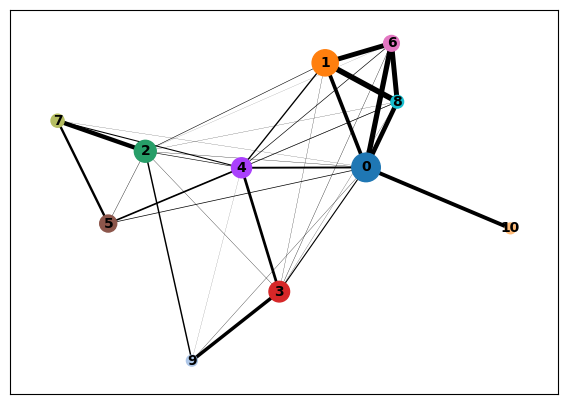

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


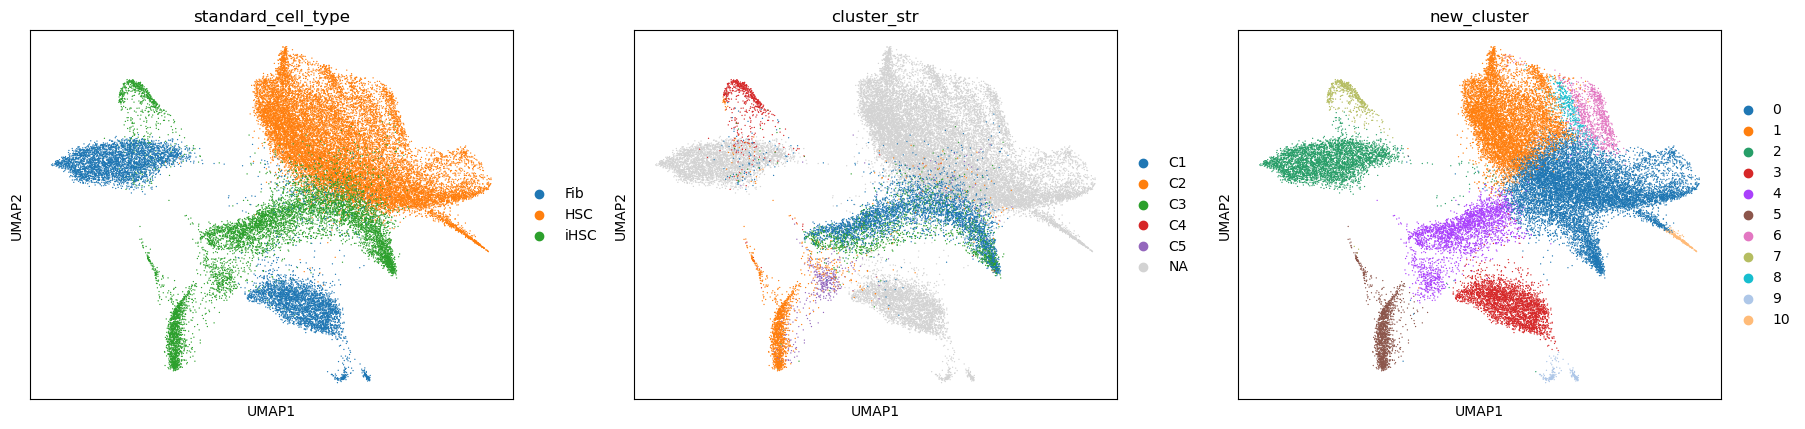

In [3]:


sc.tl.paga(
    adata,
    groups='new_cluster',
)

sc.pl.paga(
    adata,
)

sc.tl.umap(
    adata, 
    init_pos='paga',
    min_dist=0.25,
)

sc.pl.umap(
    adata,
    color=[
        'standard_cell_type',
        'cluster_str',
        'new_cluster',
    ],
)

In [4]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Load the Features

In [ ]:
fpath = "../resources/PanglaoDB_Augmented_2021.txt"

features = ut.load_pathway(fpath)
columns = [
    'Hematopoietic Stem Cells',
    'Fibroblasts',
]

marker_columns = []

for col in columns:
    gene_list = list(features[features[col]].index)
    print(col, len(gene_list))
    col_name = col.lower().replace(" ", "_") + "_marker"
    marker_columns.append(col_name)
    adata.var[col_name] = adata.var.index.isin(gene_list)
    
adata.var['is_marker'] = adata.var[marker_columns].any(axis=1)
print()
adata

In [ ]:
# break

In [ ]:
sc.pp.pca(
    adata, 
    mask_var='is_marker',
    layer='combat',
)

sc.pl.pca_variance_ratio(adata)

# Adjust the UMAP embeddings

In [ ]:
sce.pp.bbknn(
    adata, 
    batch_key='dataset',
)

sc.tl.paga(
    adata,
    groups='new_cluster',
)

sc.pl.paga(
    adata,
    # threshold=thr,
)

sc.tl.umap(
    adata, 
    init_pos='paga',
    # min_dist=0.25,
)

sc.pl.umap(
    adata,
    color=[
        'standard_cell_type',
        'cluster_str',
        'new_cluster',
    ],
)

In [ ]:
break